<a href="https://colab.research.google.com/github/Byeongsoo-Min/Machine-learning-in-practice/blob/main/Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
def make_file_list():

    train_img_dir = str()
    train_img_lists = list()
    train_img_list = list()
    train_img_dir = os.getcwd() + '/practice/Dataset/'
    train_img_lists = os.listdir(train_img_dir)
    for img_file in train_img_lists:
        train_img_list = os.listdir(train_img_dir + img_file)
        for img_idx in train_img_list:
            img_path = train_img_dir + '/' + train_img_dir + '/' + str(img_idx)
            train_img_list.append(img_path)

    return train_img_list

In [ ]:
from torchvision import datasets, models, transforms

path = 'practice/Dataset'

data_transforms= transforms.Compose([
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image_datasets = datasets.ImageFolder(path, data_transforms)
print(image_datasets)
class_names = image_datasets.classes
print(class_names)

Dataset ImageFolder
    Number of datapoints: 4811
    Root location: practice/Dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
['Chandragupta_faces', 'Cleopatra_faces', 'Cyrus_faces', 'Gandhi_faces', 'Genghis_Khan_faces', 'Gitarja_faces', 'Hammurabi_faces', 'Hojo_Tokimune_faces', 'Jadwiga _faces', 'Jayavarman_VII_faces', 'Kristina_faces', 'Kupe_faces', 'MansaMusa_faces', 'Mvemba_faces', 'Pachacuti_faces', 'Pedro_faces', 'Peter_faces', 'Philip_II_faces', 'QinShiHuang_faces', 'Robert_faces', 'Seondeok_faces', 'Simón_Bolívar_faces', 'Suleiman_faces', 'Teddy_Roosevelt_faces', 'Trajan_faces', 'Victoria_faces', 'catherine_faces', 'dido_faces']


In [ ]:
import torch
train_size = int(0.8 *len(image_datasets))
test_size = len(image_datasets) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 28, shuffle = True)

validation_loader = torch.utils.data.DataLoader(test_dataset,batch_size=28,shuffle=False)

tensor([26, 22,  9,  6, 23, 20, 17,  6,  7,  6,  7, 13,  3,  4, 16, 27,  5,  7,
        19, 22, 26, 14, 10, 10, 17, 27, 24,  3])


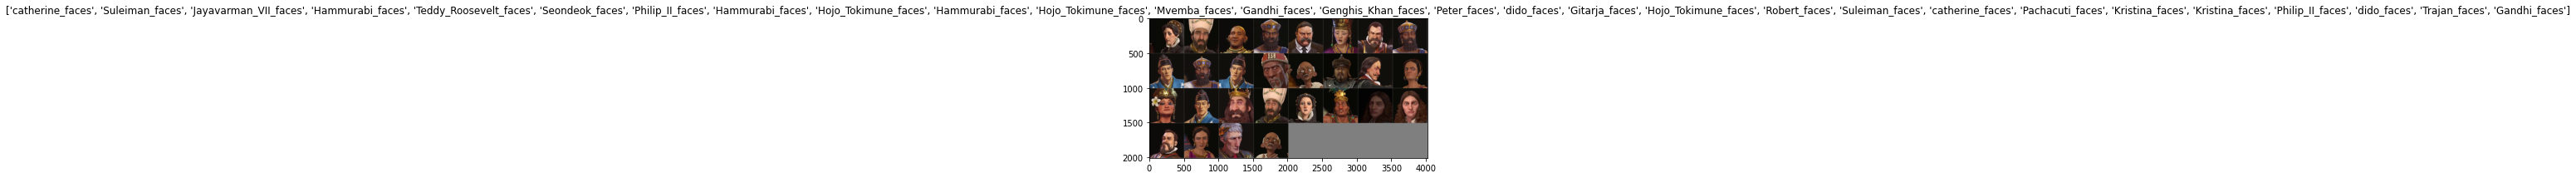

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
inputs, classes = next(iter(train_loader))
print(classes)

def imshow(inp, title=None):
	inp = inp.numpy().transpose((1, 2, 0))
	mean = np.array([0.5, 0.5, 0.5])
	std = np.array([0.5, 0.5, 0.5])
	inp = std*inp + mean
	inp = np.clip(inp, 0 ,1)
	plt.imshow(inp)
	if title is not None:
		plt.title(title)
	plt.pause(0.001)

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import os
from os import path

from facenet_pytorch import InceptionResnetV1
from network.fc_layers import Identity
import torch
from torch.utils.tensorboard import SummaryWriter
from network.TorchUtils import TorchModel
from utils.callbacks import DefaultModelCallback, TensorBoardCallback
from utils.utils import register_logger, get_torch_device


def get_args():
    parser = argparse.ArgumentParser(description="PyTorch CIV6 Face Parser")

    # io
    parser.add_argument('--inputs_path', default='features',
                        help="path to inputs")
    parser.add_argument('--log_file', type=str, default="log.log",
                        help="set logging file.")
    parser.add_argument('--exps_dir', type=str, default="exps",
                        help="path to the directory where models and tensorboard would be saved.")
    parser.add_argument('--checkpoint', type=str,
                        help="load a model for resume training")

    # optimization
    parser.add_argument('--batch_size', type=int, default=60,
                        help="batch size")
    parser.add_argument('--save_every', type=int, default=1,
                        help="epochs interval for saving the model checkpoints")
    parser.add_argument('--lr_base', type=float, default=0.01,
                        help="learning rate")
    parser.add_argument('--iterations_per_epoch', type=int, default=20000,
                        help="number of training iterations")
    parser.add_argument('--epochs', type=int, default=2,
                        help="number of training epochs")

    return parser.parse_args()



args = get_args()

register_logger()
os.makedirs(args.exps_dir, exist_ok=True)
models_dir = path.join(args.exps_dir, 'models')
tb_dir = path.join(args.exps_dir, 'tensorboard')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(tb_dir, exist_ok=True)

device = get_torch_device()

test_loader = validation_loader

if args.checkpoint is not None and path.exists(args.checkpoint):
    model = TorchModel.load_model(args.checkpoint)
else:
    model = InceptionResnetV1(pretrained='casia-webface')

    for param in model.parameters():
        param.requires_grad = False
    model.logits = Identity()
    model = TorchModel(model)

# print(model)
# for param in model.logits.parameters():
#     print(param.requires_grad)

tb_writer = SummaryWriter(log_dir=tb_dir)
model.register_callback(DefaultModelCallback(visualization_dir=args.exps_dir))
model.register_callback(TensorBoardCallback(tb_writer=tb_writer))

model = model.to(device).train()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr_base)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

model.fit(train_iter=train_loader,
            eval_iter=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            epochs=args.epoch,
            network_model_path_base=models_dir,
            save_every=args.save_every,
            evaluate_every=True)



ModuleNotFoundError: ignored